# Isochrones fititng - B90

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib widget

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/Catalogs/catalog.xym'
data = pd.read_csv(input_file, sep='\t')

mag_limit = -5. 
data_spatial = data[(data['F814W'] < mag_limit) & (data['F814W'] < mag_limit)]

In [63]:
# Plot the spatial distribution and the selected old cluster (B 90) and young one (NGC 346)

# center and approximative radius of the old cluster
center_B90 = np.array([5000, 7000])
radius_B90 = 1000

# center and approximative radius of the reference field
center_reference = np.array([3000, 3000])
radius_reference = 1000

# compute the distance and select the stars in the two clusters
data['distance_B90'] = np.sqrt((data['x'] - center_B90[0]) ** 2 + (data['y'] - center_B90[1]) ** 2)
data['distance_reference'] = np.sqrt((data['x'] - center_reference[0]) ** 2 + (data['y'] - center_reference[1]) ** 2)

data_B90_cluster = data[data['distance_B90'] < radius_B90]
data_reference_field = data[data['distance_reference'] < radius_reference]

In [64]:
import sys
import os

# set path to tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

colormap = plt.cm.jet

In [65]:
test_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/NGC346/test_stars_B90.csv', delim_whitespace=True)
print(test_stars)

test_stars['index'] = test_stars.index
color_test = binary.color_index(test_stars, 'index', colormap)

    F814W    F555W    F475W   F336W   F275W         source
0  -16.50 -15.0608 -14.3444 -9.4722 -5.6693     test_stars
1  -16.00 -14.6785 -14.0123 -9.5435 -5.9578     test_stars
2  -15.50 -14.2773 -13.6455 -9.5356 -6.1446     test_stars
3  -15.00 -13.8747 -13.2424 -9.3918 -6.3531     test_stars
4  -14.50 -13.4450 -12.8305 -9.2880 -6.3859     test_stars
5  -14.00 -12.9977 -12.4060 -9.0328 -6.4086     test_stars
6  -13.50 -12.5350 -11.9574 -8.7646 -6.3182     test_stars
7  -13.00 -12.0716 -11.5182 -8.4482 -6.1215     test_stars
8  -12.50 -11.6014 -11.0763 -8.0912 -5.8759     test_stars
9  -12.00 -11.1263 -10.6234 -7.6990 -5.5951     test_stars
10 -11.50 -10.6445 -10.1587 -7.2778 -5.3632     test_stars
11 -11.20 -10.5145 -10.0982 -7.6062 -5.9382     test_stars
12 -11.00 -10.4886 -10.1364 -7.6213 -6.4169     test_stars
13 -10.50 -10.0280  -9.7251 -7.2224 -6.2109     test_stars
14 -10.00  -9.5014  -9.1959 -6.6928 -5.7591     test_stars
15  -9.50  -8.9511  -8.6352 -6.1458 -5.2591     test_sta

In [66]:
# create a simple dataframe with the zeropoints for the calibration
zero_F814W = 32.1551
zero_F555W = 32.2380

In [67]:
# calibrate the observed magnitudes with the zeropoints
data_B90_cluster['F555W_cal'] = data_B90_cluster['F555W'] + zero_F555W
data_B90_cluster['F814W_cal'] = data_B90_cluster['F814W'] + zero_F814W

data_reference_field['F555W_cal'] = data_reference_field['F555W'] + zero_F555W
data_reference_field['F814W_cal'] = data_reference_field['F814W'] + zero_F814W

# calibrate also the test stars
test_stars['F555W_cal'] = test_stars['F555W'] + zero_F555W
test_stars['F814W_cal'] = test_stars['F814W'] + zero_F814W


Plot both the data and the isochrone, verify if the horizontal branch is present in the isochrone. If not, look for another isochrone. The isochrone will be shifted up and on the left with respect to the cluster since is at unit distance. We need to correct for distance modulus in vertical to match the cluster and the reddening to shift it in the horizontal axis. 

In [68]:
# read the isochrone data
isochrone = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/NGC346/isochrone_B90.dat', delim_whitespace=True, skiprows=13)
isochrone = isochrone.rename(columns={'F814Wmag': 'F814W', 'F555Wmag': 'F555W'})

# distance modulus and color excess E(B-V) from Milone et al. 2023
distance_modulus = 18.91
color_excess = 0.03

# coefficients for the reddening correction 
R_I = 1.8420        # F814W
R_V = 3.2118        # F555W

isochrone['F555W'] = isochrone['F555W'] + distance_modulus + color_excess * R_V
isochrone['F814W'] = isochrone['F814W'] + distance_modulus + color_excess * R_I


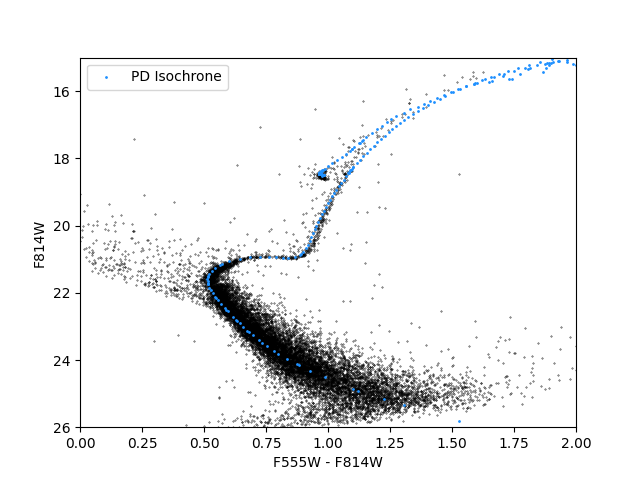

In [69]:
plt.figure()

plt.scatter(data_B90_cluster['F555W_cal'] - data_B90_cluster['F814W_cal'], data_B90_cluster['F814W_cal'], s=0.1, c='black')
plt.scatter(isochrone['F555W'] - isochrone['F814W'], isochrone['F814W'], s=1, c='dodgerblue', label='PD Isochrone')
plt.gca().invert_yaxis()

plt.xlim(0,2)
plt.ylim(26,15)

plt.xlabel('F555W - F814W')
plt.ylabel('F814W')
plt.legend()

plt.show()

In [70]:
prim_for_ratio = test_stars[test_stars['index'] == 22]
sec_for_ratio = test_stars[test_stars['index'] == 6]

prim_for_ratio_RGB = test_stars[test_stars['index'] == 10]
sec_for_ratio_RGB = test_stars[test_stars['index'] == 15]

In [71]:
# find the mass of the primary star
magnitude_prim = prim_for_ratio['F814W_cal'].values[0]
magnitude_sec = sec_for_ratio['F814W_cal'].values[0]

magnitude_prim_RGB = prim_for_ratio_RGB['F814W_cal'].values[0]
magnitude_sec_RGB = sec_for_ratio_RGB['F814W_cal'].values[0]

In [72]:
# find the point in iso_pd that is closest to the magnitude of the primary star
# define a boundary on the color F555W-F814W
isochrone_HB = isochrone[(isochrone['F555W'] - isochrone['F814W'] < 1.)]

idx_prim = (isochrone_HB['F814W']-magnitude_prim).abs().idxmin()
mass_prim = isochrone['Mini'].iloc[idx_prim]
print(mass_prim)

idx_sec = (isochrone['F814W']-magnitude_sec).abs().idxmin()
mass_sec = isochrone['Mini'].iloc[idx_sec]
print(mass_sec)


q_low = mass_sec/mass_prim
print('lowest q:', q_low)


1.1667509079
1.161631465
lowest q: 0.9956122229129314


In [73]:
# find the point in iso_pd that is closest to the magnitude of the primary star
# define a boundary on the color F555W-F814W

idx_prim_RGB = (isochrone['F814W']-magnitude_prim_RGB).abs().idxmin()
mass_prim_RGB = isochrone['Mini'].iloc[idx_prim_RGB]
print(mass_prim_RGB)

idx_sec_RGB = (isochrone['F814W']-magnitude_sec_RGB).abs().idxmin()
mass_sec_RGB = isochrone['Mini'].iloc[idx_sec_RGB]
print(mass_sec_RGB)

q_low_RGB = mass_sec_RGB/mass_prim_RGB
print('lowest q:', q_low_RGB)

1.1481124163
0.9442263842
lowest q: 0.8224163163768757


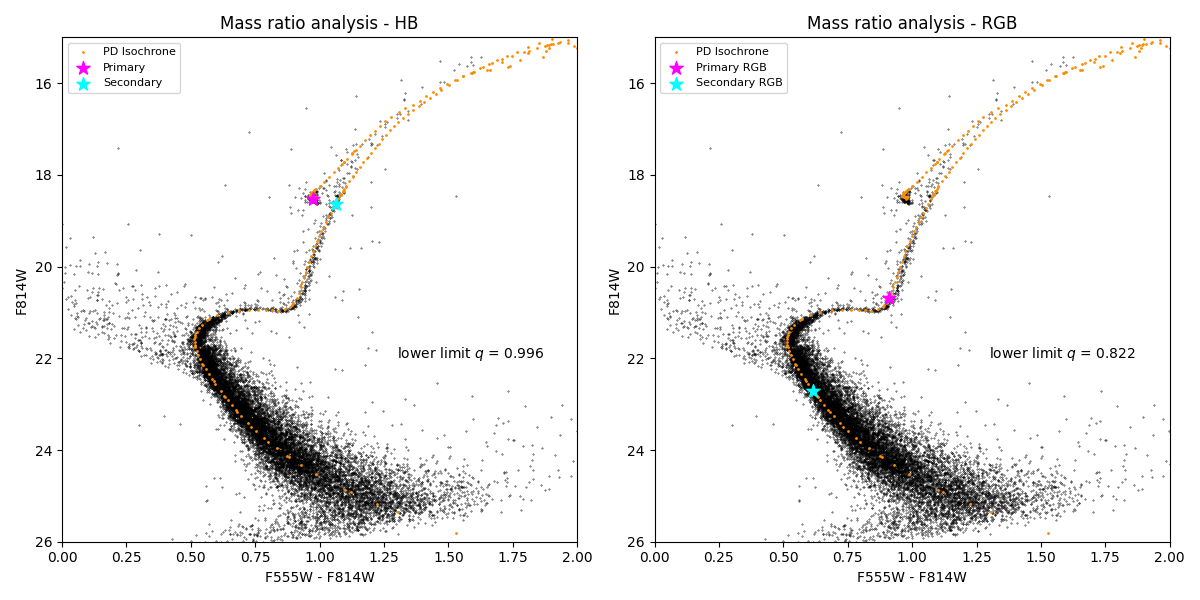

In [74]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

ax1 = axes[0]

ax1.scatter(data_B90_cluster['F555W_cal'] - data_B90_cluster['F814W_cal'], data_B90_cluster['F814W_cal'], s=0.1, c='black')
ax1.scatter(isochrone['F555W'] - isochrone['F814W'], isochrone['F814W'], s=1, c='darkorange', label='PD Isochrone')
ax1.scatter(isochrone['F555W'].iloc[idx_prim] - isochrone['F814W'].iloc[idx_prim], isochrone['F814W'].iloc[idx_prim], s=100, marker='*', c='magenta', label='Primary')
ax1.scatter(isochrone['F555W'].iloc[idx_sec] - isochrone['F814W'].iloc[idx_sec], isochrone['F814W'].iloc[idx_sec], s=100, marker='*', c='aqua', label='Secondary')

ax1.set_xlim(0,2)
ax1.set_ylim(26,15)

ax1.set_xlabel('F555W - F814W')
ax1.set_ylabel('F814W')
ax1.legend(fontsize=8)
ax1.set_title('Mass ratio analysis - HB')
ax1.text(1.3, 22, f'lower limit $q$ = {q_low:.3f}', fontsize=10, color='black')

ax2 = axes[1]
ax2.scatter(data_B90_cluster['F555W_cal'] - data_B90_cluster['F814W_cal'], data_B90_cluster['F814W_cal'], s=0.1, c='black')
ax2.scatter(isochrone['F555W'] - isochrone['F814W'], isochrone['F814W'], s=1, c='darkorange', label='PD Isochrone')
ax2.scatter(isochrone['F555W'].iloc[idx_prim_RGB] - isochrone['F814W'].iloc[idx_prim_RGB], isochrone['F814W'].iloc[idx_prim_RGB], s=100, marker='*', c='magenta', label='Primary RGB')
ax2.scatter(isochrone['F555W'].iloc[idx_sec_RGB] - isochrone['F814W'].iloc[idx_sec_RGB], isochrone['F814W'].iloc[idx_sec_RGB], s=100, marker='*', c='aqua', label='Secondary RGB')

ax2.set_xlim(0,2)
ax2.set_ylim(26,15)

ax2.set_xlabel('F555W - F814W')
ax2.set_ylabel('F814W')
ax2.legend(fontsize=8)
ax2.set_title('Mass ratio analysis - RGB')
ax2.text(1.3, 22, f'lower limit $q$ = {q_low_RGB:.3f}', fontsize=10, color='black')

plt.tight_layout()
plt.show()